<a href="https://colab.research.google.com/github/nem-42098/SL_Proj_Unlearning/blob/main/Unlearn_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/nem-42098/SL_Proj_Unlearning/blob/main/Unlearn_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/nem-42098/SL_Proj_Unlearning.git
import os
os.chdir('/content/SL_Proj_Unlearning')

Cloning into 'SL_Proj_Unlearning'...
remote: Enumerating objects: 513, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 513 (delta 131), reused 135 (delta 110), pack-reused 350
Receiving objects: 100% (513/513), 3.66 MiB | 20.71 MiB/s, done.
Resolving deltas: 100% (323/323), done.


In [152]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
import numpy as np


### Load Pre-Trained VGG network
> #### https://github.com/chenyaofo
> ### Note: There is some issue with using Batch Norm before ReLu as it creates a bias in the network. So people exchange the order between the two for tackling the bias

In [153]:
### First time when you wan to download the model
device=torch.device('cuda')
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
model=model.to(device)
### For future uses:Loading from the local

# model_1=torch.hub.load("C:/Users/nmura/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master",'hubconf.py',source='local')



Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


### Check which pre-trained model are available:

In [ ]:
torch.hub.list("chenyaofo/pytorch-cifar-models", force_reload=True)

### Downlaoding the Dataset and Creating the Dataloaders

In [154]:
### Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    )
])
### Pytorch Datasets
train_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = transform)
### Dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [155]:
len(train_dataset)

50000

### Create the Forget Dataset

In [156]:
# Define the classes
classes = ['forget', 'retain']

# Create a dictionary to store datasets for each class
class_datasets = {class_name: [] for class_name in classes}

# Iterate through the CIFAR-10 dataset and split it into class-specific subsets
for image, label in train_dataset:
  if label == 1:
    class_datasets['forget'].append((image, label))

  else:
      class_datasets['retain'].append((image, label))

# You now have class-specific subsets in the class_datasets dict


#### Forget and Retain

In [157]:
# Class split
retain_dataloader = torch.utils.data.DataLoader(class_datasets['retain'], batch_size=128, shuffle=True, num_workers=2)
forget_dataloader = torch.utils.data.DataLoader(class_datasets['forget'], batch_size=128, shuffle=True, num_workers=2)

# Random split
# train_split_dataset,forget_split_dataset=torch.utils.data.random_split(train_dataset,lengths=[45000,5000])
# retain_dataloader = torch.utils.data.DataLoader(train_split_dataset,  batch_size=128, shuffle=True, num_workers=2)
# forget_dataloader = torch.utils.data.DataLoader(forget_split_dataset, batch_size=128, shuffle=True, num_workers=2)

# Unlearner class


## Check that dumb model output random values
We expect this values to be uniform in [0,9], thus accuracy to be 10%.

In [158]:
from tools.Unlearner import Unlearner

unlearner = Unlearner(model, lr = 1e-6, alpha=1)
ignorant = unlearner.reset_weights(model)

def test(model, dataloader):
  tp, n = 0,0
  for X,y in dataloader:
    X,y = X.to(device), y.to(device)

    with torch.no_grad():
      y_pred = model(X)

    tp += (y_pred.argmax(axis=1) == y).sum().item()
    n  += y.size(0)

  return tp/n

test(ignorant, forget_dataloader)

0.4738

## Run the unlearning


In [177]:
from tools.Unlearner import Unlearner

unlearner = Unlearner(model, lr = 1e-6, alpha=0.5)

unlearn_model = unlearner.unlearn(retain_dataloader, forget_dataloader, forget_epochs=15)

100%|██████████| 4/4 [01:02<00:00, 15.63s/it]


We can see that the unlearning process may need many epochs in the erasure phase to converge. We could also try to increase the learning rate for faster convergence.

<Axes: xlabel='epoch', ylabel='loss_scale'>

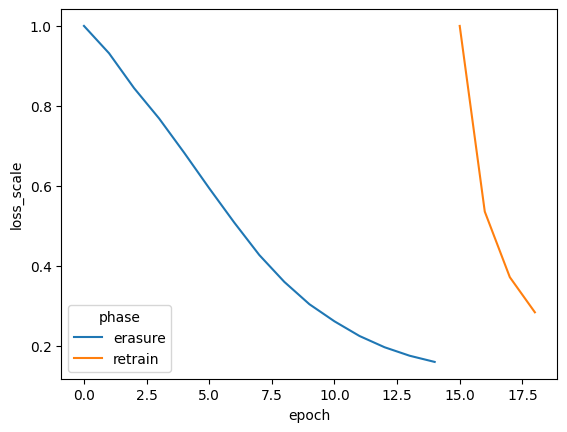

In [178]:
import pandas as pd
import seaborn as sns

log_df = pd.DataFrame.from_records(unlearner.log, columns=['phase', 'epoch', 'batch', 'tp', 'n', 'loss'])
unlearn_history = log_df.groupby(['phase', 'epoch']).agg({'tp':sum, 'n':sum, 'loss': 'mean'}).reset_index()
unlearn_history['accuracy'] = unlearn_history.tp / unlearn_history.n
unlearn_history.loc[unlearn_history.phase == 'erasure', 'loss_scale'] = unlearn_history.loc[unlearn_history.phase == 'erasure', 'loss'] /unlearn_history.loc[unlearn_history.phase == 'erasure', 'loss'].max()
unlearn_history.loc[unlearn_history.phase == 'retrain', 'loss_scale'] = unlearn_history.loc[unlearn_history.phase == 'retrain', 'loss'] /unlearn_history.loc[unlearn_history.phase == 'retrain', 'loss'].max()

sns.lineplot(data = unlearn_history, x = 'epoch', y='loss_scale', hue='phase')

## Check model performance
We now try check the model performance on the retain and forget set.

In [179]:
models = {'original':model, 'erased':unlearner.erased_model, 'retrained':unlearner.retrained_model}
dataloaders = {'retain':retain_dataloader, 'forget':forget_dataloader, 'test':testloader}

performances = []
for model_name, m in models.items():
  for dl_name, dl in dataloaders.items():
    acc = test(m, dl)
    performances.append((model_name, dl_name, acc))

Strangely the dumb network has 0% performance on the forget set, and this may have a negative impact, note that the performance on the forget set is even too low (we expected 10%, not less).

Outside of that we note that this procedure works great for the retain and test which are fitted very nicely, and we can even see that there's a big leap in performance from the erased model to the retrained model.

<Axes: xlabel='model', ylabel='data_partition'>

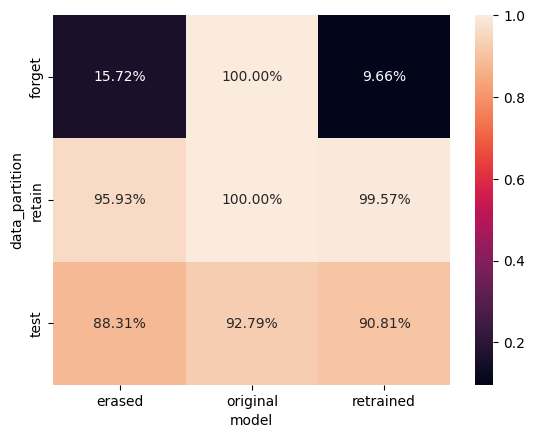

In [180]:
perf_df = pd.DataFrame.from_records(performances, columns=['model', 'data_partition', 'accuracy'])

tb = pd.pivot_table(perf_df, index='data_partition', columns='model', values='accuracy')
sns.heatmap(tb, annot = True, fmt='.2%')

## Run the unlearning algorithm for different hyperparamters

### Learning rate

In [197]:
from sklearn.model_selection import ParameterGrid
grid = {'epochs':  [1,3,5,7,10,12,15,20, 25, 30, 40]}

acc_forget = list()
acc_retain = list()
acc_test = list()

for params in ParameterGrid(param_grid=grid):
  unlearner = Unlearner(model, lr = 1e-6, alpha=0.5)

  unlearn_model = unlearner.unlearn(retain_dataloader, forget_dataloader, forget_epochs=params['epochs'])

  acc_forget.append(test(unlearn_model, forget_dataloader))
  acc_retain.append(test(unlearn_model, retain_dataloader))
  acc_test.append(test(unlearn_model, testloader))



100%|██████████| 4/4 [01:01<00:00, 15.49s/it]


In [199]:
np.linspace(1,30,10, dtype=np.int64)

array([ 1,  4,  7, 10, 13, 17, 20, 23, 26, 30])

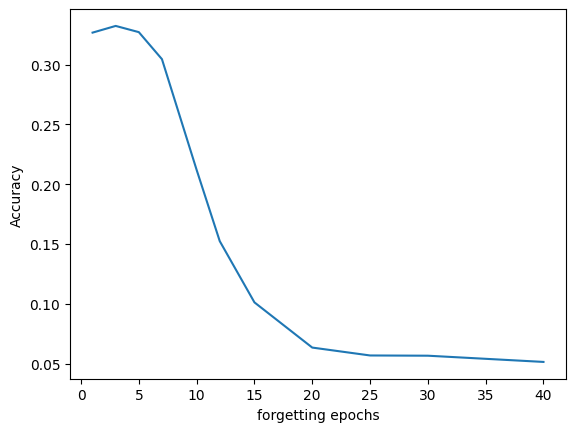

In [202]:
ax = sns.lineplot(x=grid['epochs'], y = acc_forget)

ax.set(xlabel = 'forgetting epochs', ylabel = 'Accuracy')

plt.show()

In [204]:
from sklearn.model_selection import ParameterGrid
grid = {'lr': [1e-9, 0.5e-8, 1e-8, 0.5e-7, 1e-7,0.5e-6, 1e-6, 1e-5]}

acc_forget = list()
acc_retain = list()
acc_test = list()

for params in ParameterGrid(param_grid=grid):
  unlearner = Unlearner(model, lr = params['lr'], alpha=0.5)

  unlearn_model = unlearner.unlearn(retain_dataloader, forget_dataloader, forget_epochs=15)

  acc_forget.append(test(unlearn_model, forget_dataloader))
  acc_retain.append(test(unlearn_model, retain_dataloader))
  acc_test.append(test(unlearn_model, testloader))

100%|██████████| 4/4 [01:02<00:00, 15.71s/it]


In [171]:
list(grid['lr'])

[1e-09, 1e-08, 5e-09, 1e-07, 5e-08, 1e-06, 5e-07, 1e-05]

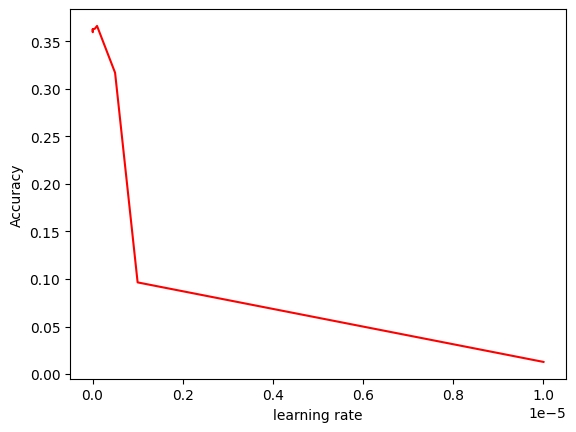

In [209]:
ax = sns.lineplot(x=grid['lr'], y = acc_forget, color='red')
ax.set(xlabel = 'learning rate', ylabel = 'Accuracy' )

plt.show()

### Run the unlearning algorithm for different values of alpha

In [187]:
alpha = [1e-4, 1e-3, 1e-2, 0.5, 1]
res_acc_retain = dict()

for param in alpha:
  unlearner = Unlearner(model, lr = 1e-6, alpha=param)

  unlearn_model = unlearner.unlearn(retain_dataloader, forget_dataloader, forget_epochs=17)

  log_df = pd.DataFrame.from_records(unlearner.log, columns=['phase', 'epoch', 'batch', 'tp', 'n', 'loss'])
  unlearn_history = log_df.groupby(['phase', 'epoch']).agg({'tp':sum, 'n':sum, 'loss': 'mean'}).reset_index()
  unlearn_history['accuracy'] = unlearn_history.tp / unlearn_history.n

  acc_before_retraining = test(unlearner.erased_model, retain_dataloader)
  res_acc_retain[param] = [acc_before_retraining] + list(unlearn_history.loc[unlearn_history['phase'] == 'retrain']['accuracy'])




100%|██████████| 4/4 [01:02<00:00, 15.51s/it]


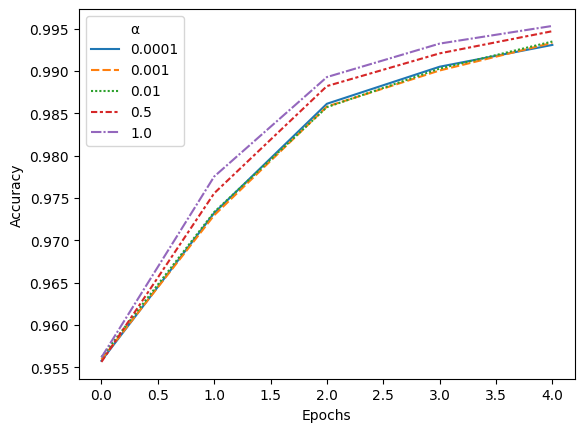

In [191]:
ax = sns.lineplot(pd.DataFrame(res_acc_retain))
ax.set(xlabel = 'Epochs', ylabel = 'Accuracy')
plt.legend(title='α')
plt.sa
plt.show()

In [182]:
original_retain = test(model, retain_dataloader)
original_forget = test(model, forget_dataloader)
original_test = test(model, testloader)

unlearn_retain = test(unlearn_model, retain_dataloader)
unlearn_forget = test(unlearn_model, forget_dataloader)
unlearn_test = test(unlearn_model, testloader)



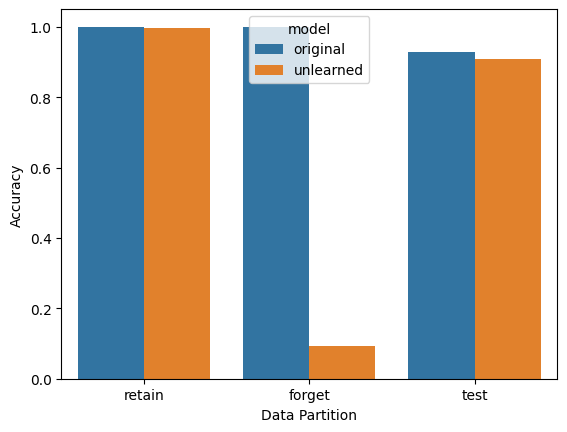

In [184]:
res = {'Accuracy': [original_retain, original_forget, original_test, unlearn_retain, unlearn_forget, unlearn_test], 'model' : 3*['original'] +
       3*['unlearned'], 'data_partition': ['retain','forget','test'] *2}
df = pd.DataFrame(res)

import matplotlib.pyplot as plt

ax = sns.barplot(df, x=df.data_partition, y=df.Accuracy, hue = df.model )
ax.set(xlabel = 'Data Partition', ylabel = 'Accuracy')

plt.show()

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
target_layers = [model.features[-3]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
inv_normalize = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = (1/0.2023, 1/0.1994, 1/0.2010)),
    transforms.Normalize(mean = (-0.4914, -0.4822, -0.4465), std = [ 1., 1., 1. ])])

for i, (image, label) in enumerate(train_dataset):
    X = image.to('cuda')[None, :,:,:]
    grayscale_cam = cam(input_tensor=X)

    grayscale_cam = grayscale_cam[0, :]
    img = inv_normalize(X).squeeze().detach().cpu().numpy().clip(0,1).transpose((1, 2, 0))
    g = img* np.repeat(grayscale_cam[:,:,None]>0.75, 3, 2)
    plt.imshow(g)
    print(i, label)
    plt.show()

    if i==10:
        break

In [ ]:
!pip install grad_cam
!pip install shap
!pip install git+https://github.com/pytorch/captum.git
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
from torchvision import models, transforms
from captum.attr import Saliency
from captum.attr import visualization as viz


saliency = Saliency(unlearner.retrained_model)

for X, y in retain_dataloader:
    img = X[:1].to(device)
    label = LABELS[y[0]]
    saliency_map = saliency.attribute(img, target=y[0])
    break


print(label)
viz.visualize_image_attr(
    saliency_map[0].cpu().permute(1,2,0).detach().numpy(),
    original_image = inv_normalize(img).squeeze().detach().cpu().numpy().clip(0,1).transpose((1, 2, 0)),
    method="blended_heat_map", sign="absolute_value", show_colorbar=True, alpha_overlay=0.3)
